# Evaluation

In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import torch
import pandas as pd
from src import fishfactor
import matplotlib.pyplot as plt
import pyro
from src import utils
import numpy as np
import seaborn as sns
import matplotlib

### Data

In [2]:
n_cells = 20

results = torch.load('results_%s/results_final.pkl' %n_cells, map_location='cpu')

data = pd.read_feather('../data/nih3t3/preprocessed_data.feather')

protrusion_genes = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1', 'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1', 'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nucleus_perinucleus_genes = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn', 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6', 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
cytoplasm_genes = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1', 'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1', 'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']
cluster_genes = protrusion_genes + nucleus_perinucleus_genes + cytoplasm_genes

genes = pd.DataFrame({
    'feature' : protrusion_genes + nucleus_perinucleus_genes + cytoplasm_genes,
    'cluster_id' : [0] * len(protrusion_genes) + [1] * len(nucleus_perinucleus_genes) + [2] * len(cytoplasm_genes)})

data = data[data.gene.isin(cluster_genes)]
data['group'] = data['experiment'].astype(str) + '_' + data['fov'].astype(str) + '_' + data['cell'].astype(str)
data = data.rename(columns={'gene' : 'feature'})
data = data[['x', 'y', 'feature', 'group']]

groups = data.group.unique()[:n_cells]
data = data[data.group.isin(groups)]

data = pd.merge(data, genes, on='feature')

### Model

In [4]:
pyro.clear_param_store()

model = fishfactor.FISHFactor(
    data=data,
    n_latents=results['K'],
    nu=results['nu'],
    n_inducing=results['n_inducing'],
    grid_resolution=results['grid_resolution'],
    device='cpu',
).to(device='cpu')

model.load_state_dict(results['state_dict'])
for m in range(model.M):
    model.gp_list[m].load_state_dict(results['gp_state_dicts'][m])

### Inferred factors and weights

In [5]:
z_list = []
for m in range(model.M):
    model.gp_list[m].eval()
    mask = model.masks[m].cpu().to(dtype=torch.float32)
    mask[mask < 0.5] = np.nan
    z = utils.gp_percentiles(model.gp_list[m], model.grid)[0].cpu().view(-1, model.grid_resolution, model.grid_resolution)
    z *= mask
    z = torch.nn.Softplus()(z)
    z_list.append(z)

z = torch.stack(z_list, dim=0)

w = results['pyro_params']['w_loc_raw'].cpu().detach().squeeze()
w = torch.nn.Softplus()(w)

outputscales = []
for m in range(model.M):
    outputscales.append(model.gp_list[m].covar_module.outputscale)
outputscales = torch.stack(outputscales)

# normalize weights to maximum 1
outputscales *= w.max(dim=0).values.view(1, -1)
z *= w.max(dim=0).values.view(1, -1, 1, 1)
w /= w.max(dim=0, keepdim=True).values

### Gene clustering with inferred weights

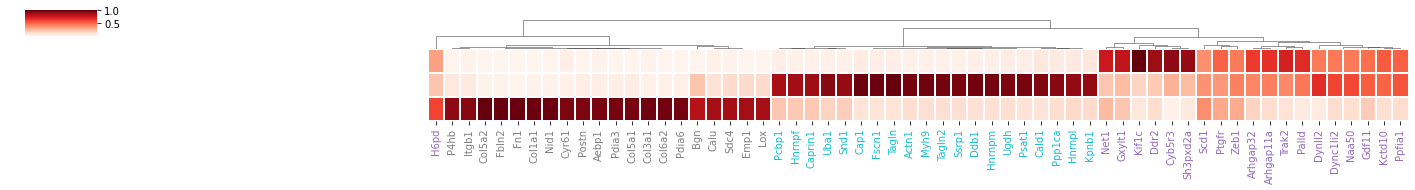

In [7]:
w_df = pd.DataFrame(w.numpy())
w_df.columns = ['f%s' %i for i in range(w.shape[-1])]
w_df['feature'] = data.feature.unique()
w_df = pd.merge(w_df, genes, on='feature')

clustergrid = sns.clustermap(w_df[['f0', 'f1', 'f2']].values.T, cmap='Reds', row_cluster=False, figsize=(20, 2), dendrogram_ratio=0.3, linewidths=0.05)

indices = clustergrid.dendrogram_col.reordered_ind

clustergrid.ax_heatmap.set_xticks(np.arange(w.shape[0]) + 0.5)
clustergrid.ax_heatmap.set_xticklabels(w_df.iloc[indices].feature, rotation='vertical')
clustergrid.ax_heatmap.set_yticks([])
for i in range(w.shape[0]):
    cluster_id = w_df.iloc[indices].cluster_id.values[i]
    clustergrid.ax_heatmap.get_xticklabels()[i].set_color('C%s' %[4, 7, 9][cluster_id]) 

plt.show()

### Cell clustering with inferred factor scale parameters

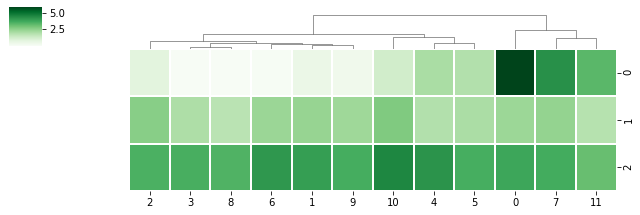

In [10]:
sns.clustermap(outputscales.detach().numpy()[:12].T, cmap='Greens', figsize=(9, 3), row_cluster=False, linewidths=0.05)
clustergrid.ax_heatmap.set_yticks([])
plt.show()

### Factors

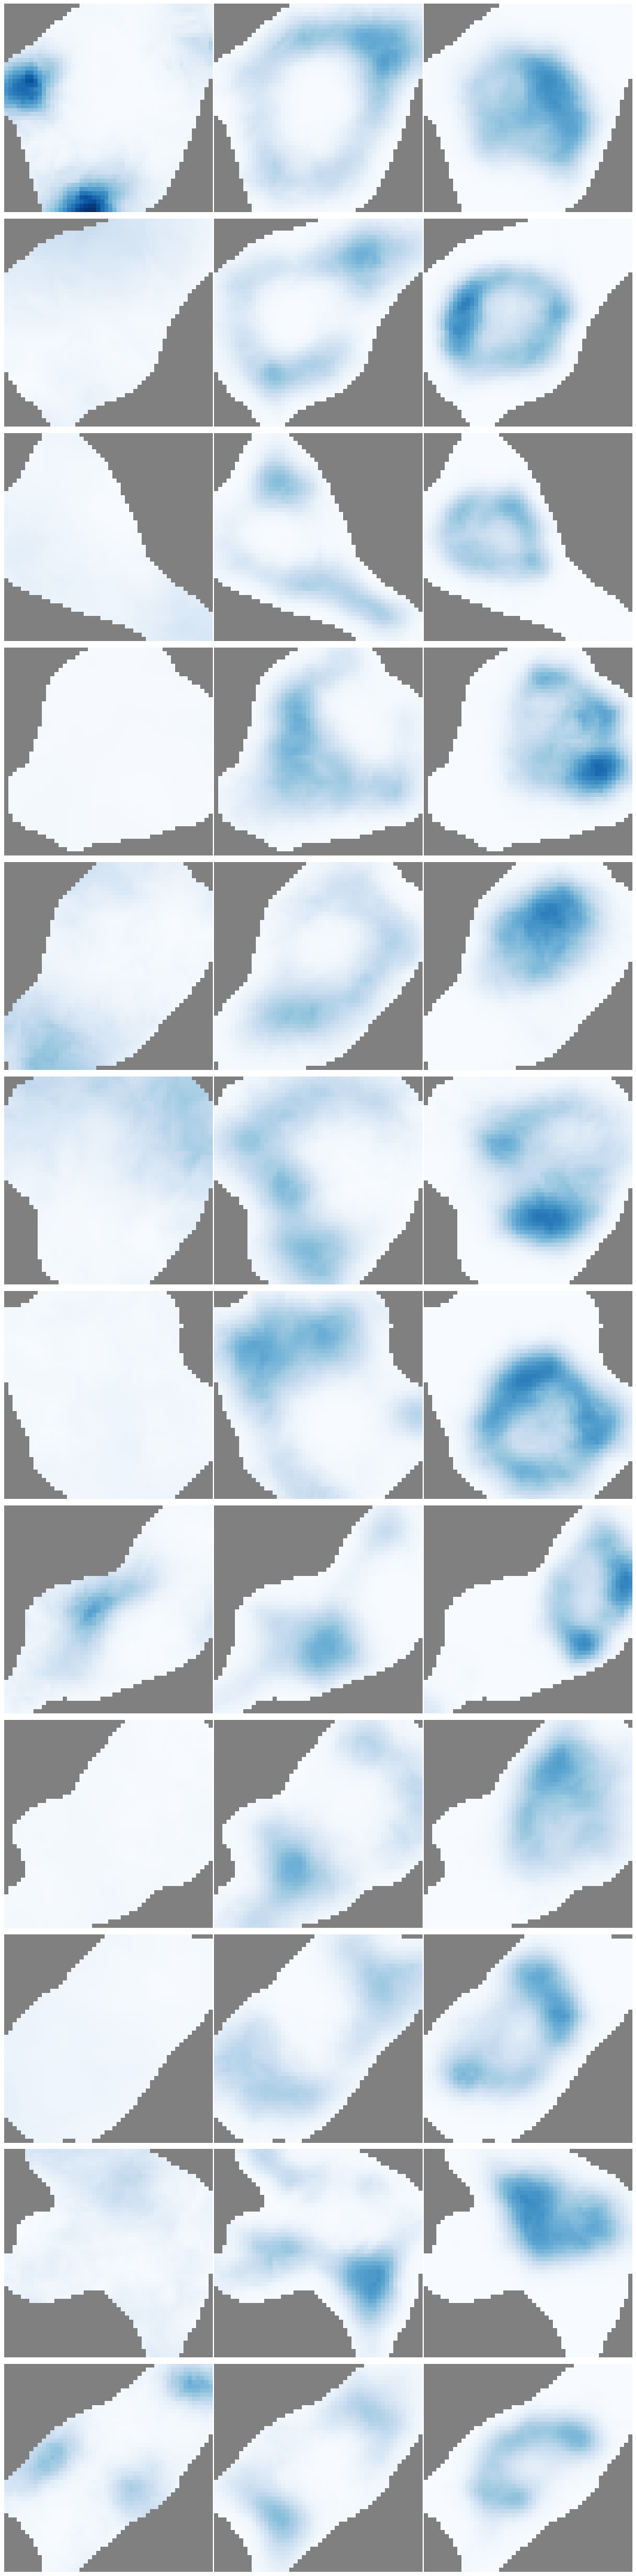

In [12]:
fig, axs = plt.subplots(12, model.K, figsize=(model.K * 5, 12 * 5))
axs = axs.reshape(-1, model.K)

for m in range(12):
    for k in range(model.K):
        cmap = matplotlib.cm.Blues.copy()
        cmap.set_bad(color='grey')
        im = axs[m][k].matshow(z[m][k], origin='lower', cmap=cmap, vmax=z[~torch.isnan(z)].max())
        axs[m][k].axis('off')

plt.tight_layout()
plt.show()

### Gene clustering at cellular level without spatial information

In [13]:
n_cells = 20

data = pd.read_feather('../data/nih3t3/preprocessed_data.feather')

protrusion_genes = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1', 'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1', 'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nucleus_perinucleus_genes = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn', 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6', 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
cytoplasm_genes = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1', 'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1', 'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']
cluster_genes = protrusion_genes + nucleus_perinucleus_genes + cytoplasm_genes

genes = pd.DataFrame({
    'feature' : protrusion_genes + nucleus_perinucleus_genes + cytoplasm_genes,
    'cluster_id' : [0] * len(protrusion_genes) + [1] * len(nucleus_perinucleus_genes) + [2] * len(cytoplasm_genes)})

data['group'] = data['experiment'].astype(str) + '_' + data['fov'].astype(str) + '_' + data['cell'].astype(str)
data = data.rename(columns={'gene' : 'feature'})
data = data[['x', 'y', 'feature', 'group']]

groups = data.group.unique()[:n_cells]
data = data[data.group.isin(groups)]

data = pd.merge(data, genes, on='feature', how='left')

In [14]:
count_table = data.groupby(['group', 'feature']).size().reset_index().pivot('group', 'feature').fillna(0)

normalized_counts = np.log(count_table.values / count_table.values.sum(axis=1, keepdims=True) * 10000 + 1)
normalized_count_table = pd.DataFrame(normalized_counts, columns=count_table.columns, index=count_table.index)
normalized_count_table.columns = normalized_count_table.columns.droplevel(0)

subset_normalized_counts = normalized_count_table[normalized_count_table.columns.intersection(cluster_genes)]

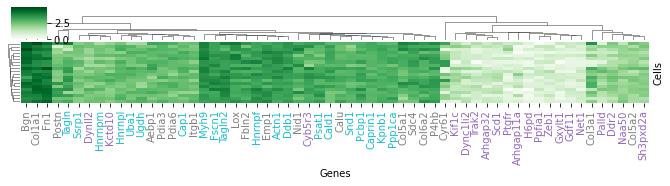

In [16]:
clustergrid = sns.clustermap(subset_normalized_counts, figsize=(10, 2.5), dendrogram_ratio=[0.02, 0.3], cmap='Greens')
col_inds = clustergrid.dendrogram_col.reordered_ind
clustergrid.ax_heatmap.set_xticks(np.arange(60) + 0.5)
clustergrid.ax_heatmap.set_xticklabels(subset_normalized_counts.columns[col_inds])
clustergrid.ax_heatmap.set_yticks([])
clustergrid.ax_heatmap.set_xlabel('Genes')
clustergrid.ax_heatmap.set_ylabel('Cells')

ordered_genes = pd.DataFrame({'feature' : subset_normalized_counts.columns[col_inds]})
cluster_inds = pd.merge(ordered_genes, genes, on='feature').cluster_id.values

for i in range(60):
    clustergrid.ax_heatmap.get_xticklabels()[i].set_color('C%s' %[4, 7, 9][cluster_inds[i]]) 

plt.show()